In [110]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from datetime import datetime
from utils.mvo_strategy import MVOPortfolio

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
sector_tickers = [
    "XLF",  # Financials
    "XLK",  # Technology
    "XLV",  # Health Care
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLE",  # Energy
    "XLI",  # Industrials
    "XLU",  # Utilities
    "XLB",  # Materials
    "XLRE",  # Real Estate
    "XLC",  # Communication Services
]

# import data from csv
df_ret = pd.read_parquet("../data/returns.parquet")
df_prices = pd.read_parquet("../data/prices.parquet")
df_vol = pd.read_parquet("../data/vola.parquet")

df_spy = pd.read_parquet("../data/prices_sp500.parquet")

In [112]:
# Test different lookback periods
lookback_periods = [10, 30, 60, 90, 120, 150, 252, 252 * 2, 252 * 3, 252 * 3.5]
# make sure all are integers
lookback_periods = [int(period) for period in lookback_periods]

# full date range from paper
START_DATE = "2012-01-01"
END_DATE = "2021-12-31"

# yr = 2011
# START_DATE = f"{yr}-01-01"
# END_DATE = f"{yr}-12-31"

In [113]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
# also add start and end date to the name
results_dir = f"../results/{timestamp}_mvo_backtest_[{START_DATE},{END_DATE}]/"
os.makedirs(results_dir, exist_ok=True)

In [114]:
all_history = []
all_metrics = []

for lookback in lookback_periods:
    print(f"Running MVO with lookback period: {lookback}")
    optimizer = MVOPortfolio(tickers=sector_tickers, lookback=lookback)
    portfolio = optimizer.backtest(
        df_ret, df_prices, start_date=START_DATE, end_date=END_DATE
    )

    portfolio_df = pd.DataFrame(portfolio.get_history())
    portfolio_df["lookback"] = lookback

    portfolio_metrics = portfolio.calc_metrics()
    portfolio_metrics["lookback"] = lookback

    all_history.append(portfolio_df)
    all_metrics.append(portfolio_metrics)

Running MVO with lookback period: 10


Running backtest: 100%|██████████| 2610/2610 [00:21<00:00, 122.00it/s]


Running MVO with lookback period: 30


Running backtest: 100%|██████████| 2610/2610 [00:23<00:00, 110.53it/s]


Running MVO with lookback period: 60


Running backtest: 100%|██████████| 2610/2610 [00:26<00:00, 97.94it/s] 


Running MVO with lookback period: 90


Running backtest: 100%|██████████| 2610/2610 [00:28<00:00, 91.05it/s] 


Running MVO with lookback period: 120


Running backtest: 100%|██████████| 2610/2610 [00:31<00:00, 83.40it/s] 


Running MVO with lookback period: 150


Running backtest: 100%|██████████| 2610/2610 [00:32<00:00, 80.94it/s] 


Running MVO with lookback period: 252


Running backtest: 100%|██████████| 2610/2610 [00:34<00:00, 76.31it/s] 


Running MVO with lookback period: 504


Running backtest: 100%|██████████| 2610/2610 [00:39<00:00, 66.53it/s]


Running MVO with lookback period: 756


Running backtest: 100%|██████████| 2610/2610 [00:39<00:00, 66.45it/s]


Running MVO with lookback period: 882


Running backtest: 100%|██████████| 2610/2610 [00:39<00:00, 65.87it/s]


In [115]:
# Combine all results
history_df = pd.concat(all_history, axis=0)
metrics_df = pd.DataFrame(all_metrics)

history_df.to_parquet(f"{results_dir}/mvo_history.parquet")
metrics_df.to_csv(f"{results_dir}/mvo_metrics.csv")

In [116]:
# # Load df from previous run
# results_dir = "../results/20250602_010152_mvo_backtest"
# history_df = pd.read_parquet(f"{results_dir}/mvo_history.parquet")
# metrics_df = pd.read_csv(f"{results_dir}/mvo_metrics.csv")

In [117]:
# compare with portfolio value development if i just buy and hold SPY
initial_balance = 100_000
shares_spy = initial_balance / df_spy["^GSPC"].loc[df_spy.index > START_DATE].iat[0]

# print(df_spy["^GSPC"].loc[END_DATE] * shares_spy)
# get closest date in df_spy thats before END_DATE
spy_lastdate = df_spy["^GSPC"].loc[df_spy.index < END_DATE].index.max()
spy_lastval = (df_spy.loc[spy_lastdate] * shares_spy).values[0]
print(f"SnP500 final value: {spy_lastval:.2f}")

# compare if MVO with lookback outperforms SnP500
# simple comparison with True False in new column
df = history_df.groupby("lookback")[['portfolio_value']].last().sort_values(by="portfolio_value", ascending=False)
df["outperforms_spy"] = df["portfolio_value"] > spy_lastval
df

SnP500 final value: 374197.75


,portfolio_value,outperforms_spy
lookback,,
756,511154.725419,True
882,481664.969894,True
150,464049.269576,True
504,357970.770858,False
10,340815.879120,False
120,306079.983467,False
252,305516.325553,False
90,235801.871653,False
30,182214.209914,False


In [118]:
# reset sns style
sns.reset_defaults()

# PLOT Portfolio Value Development
plt.figure(figsize=(15, 5))
palette = sns.color_palette(
    "coolwarm", as_cmap=False, n_colors=history_df["lookback"].nunique()
)
sns.lineplot(
    data=history_df, x="date", y="portfolio_value", hue="lookback", palette=palette, lw=1
)

plt.plot(df_spy["^GSPC"].loc[START_DATE:END_DATE] * shares_spy, c="k", label="SnP500", lw=1)

plt.title("Portfolio Value Development by Lookback Period")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
# save plot
plt.savefig(f"{results_dir}/portfolio_value_development.pdf", dpi=300)

In [121]:
# Filter relevant lookback
lookback = 60
focus_df = history_df[history_df['lookback'] == lookback]

# === Monthly returns ===
month_df = focus_df[['portfolio_value']].resample('ME').last()
month_df = pd.concat(
    [pd.DataFrame({'portfolio_value': [initial_balance]}, index=[month_df.index.min() - pd.DateOffset(months=1)]), month_df]
)
month_df['monthly_ret'] = month_df['portfolio_value'].pct_change() * 100
month_df = month_df.iloc[1:]
month_df['year'] = month_df.index.year
month_df['month'] = month_df.index.month
monthly_pivot = month_df.pivot(index='year', columns='month', values='monthly_ret')
monthly_pivot = monthly_pivot.sort_index(ascending=True)  # TODO implemented: ascending years

monthly_rets = month_df['monthly_ret'].values

# === Annual returns ===
annual_df = focus_df[['portfolio_value']].resample('YE').last()
annual_df = pd.concat(
    [pd.DataFrame({'portfolio_value': [initial_balance]}, index=[annual_df.index.min() - pd.DateOffset(years=1)]), annual_df]
)
annual_df['annual_ret'] = annual_df['portfolio_value'].pct_change() * 100
annual_df = annual_df.iloc[1:]
annual_df['year'] = annual_df.index.year
annual_df = annual_df.sort_values(by='year')  # TODO implemented: ascending years
annual_mean = annual_df['annual_ret'].mean()

# === PLOT with square plots and updated formatting ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.set_theme()

# 1. Monthly heatmap
sns.heatmap(
    monthly_pivot,
    cmap="RdYlGn",
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[0],
    cbar=False,
    linewidths=0.2,
    linecolor='white'
)
axes[0].set_title("Monthly returns (%)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Year")
axes[0].set_aspect('equal')

# 2. Annual returns bar chart (scaled to %)
axes[1].barh(annual_df['year'], annual_df['annual_ret'], color="cornflowerblue")
axes[1].axvline(x=annual_mean, color="dodgerblue", linestyle="--", lw=3, label="Mean")
axes[1].set_title("Annual returns")
axes[1].set_yticks(annual_df['year'])

# 3. Monthly return distribution
axes[2].hist(monthly_rets, bins=20, color="#ff5812", edgecolor="white")
axes[2].axvline(x=monthly_rets.mean(), color="gold", linestyle="--", lw=3, label="Mean")
axes[2].set_title("Distribution of monthly returns")
axes[2].set_ylabel("Number of months")

# Formatting for bar charts and hist
for idx in [1, 2]:
    axes[idx].axvline(x=0, color="black", lw=2)
    axes[idx].set_xlabel("Returns (%)")
    axes[idx].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    axes[idx].legend()

# Super title and layout
plt.suptitle(f"Returns for lookback = {lookback}")
plt.tight_layout()
plt.savefig(f"{results_dir}/paper_figure4_returns_{lookback}.pdf", dpi=300)

In [126]:
# Filter relevant lookback
lookback = 60
focus_df = history_df[history_df['lookback'] == lookback]

# === Monthly returns ===
month_df = focus_df[['portfolio_value']].resample('ME').last()
month_df = pd.concat([pd.DataFrame({'portfolio_value': [initial_balance]}, index=[month_df.index.min() - pd.DateOffset(months=1)]), month_df])
month_df['monthly_ret'] = month_df['portfolio_value'].pct_change() * 100
month_df = month_df.iloc[1:]
month_df['year'] = month_df.index.year
month_df['month'] = month_df.index.month
monthly_pivot = month_df.pivot(index='year', columns='month', values='monthly_ret')
monthly_rets = month_df['monthly_ret'].values

# === Annual returns ===
annual_df = focus_df[['portfolio_value']].resample('YE').last()
annual_df = pd.concat([pd.DataFrame({'portfolio_value': [initial_balance]}, index=[annual_df.index.min() - pd.DateOffset(years=1)]), annual_df])
annual_df['annual_ret'] = annual_df['portfolio_value'].pct_change() * 100
annual_df = annual_df.iloc[1:]
annual_df['year'] = annual_df.index.year
annual_mean = annual_df['annual_ret'].mean()

# === PLOT with square plots and updated formatting ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.set_theme()

# 1. Monthly heatmap
sns.heatmap(
    monthly_pivot,
    cmap="RdYlGn",
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[0],
    cbar=False,
    linewidths=0.2,
    linecolor='white'
)
axes[0].set_title("Monthly returns (%)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Year")
axes[0].set_aspect('equal')

# 2. Annual returns bar chart (scaled to %)
axes[1].barh(annual_df['year'], annual_df['annual_ret'], color="cornflowerblue")
axes[1].axvline(x=annual_mean, color="dodgerblue", linestyle="--", lw=3, label="Mean")
axes[1].set_title("Annual returns")
axes[1].set_yticks(annual_df['year'])
axes[1].invert_yaxis()

# 3. Monthly return distribution
axes[2].hist(monthly_rets, bins=20, color="#ff5812", edgecolor="white")
axes[2].axvline(x=monthly_rets.mean(), color="gold", linestyle="--", lw=3, label="Mean")
axes[2].set_title("Distribution of monthly returns")
axes[2].set_ylabel("Number of months")

for idx in [1,2]:
    axes[idx].axvline(x=0, color="black", lw=2)
    axes[idx].set_xlabel("Returns (%)")
    axes[idx].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    axes[idx].legend()

plt.suptitle(f"Returns for lookback = {lookback}")

plt.tight_layout()
plt.savefig(f"{results_dir}/paper_figure4_returns_{lookback}.pdf", dpi=300)

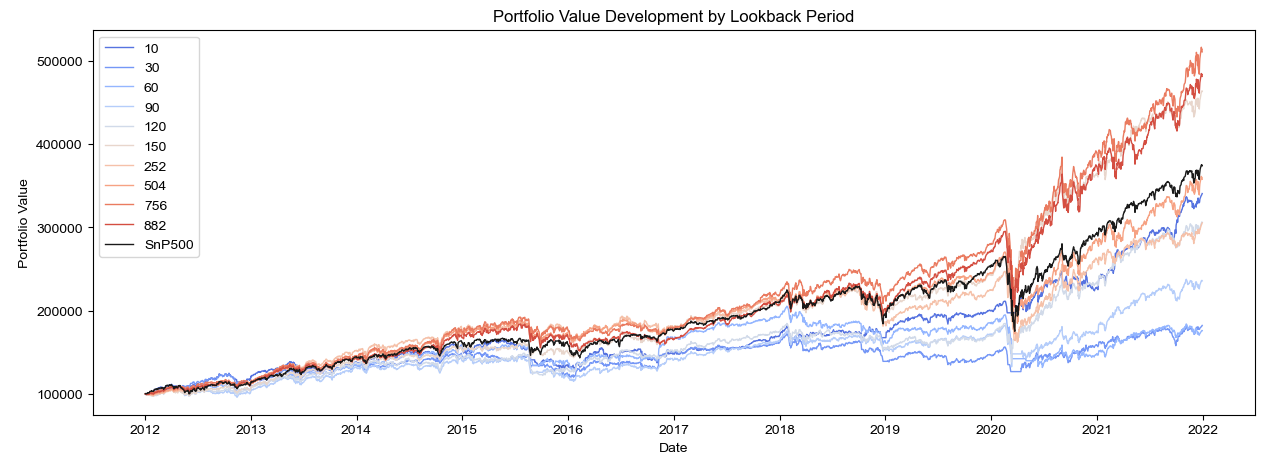

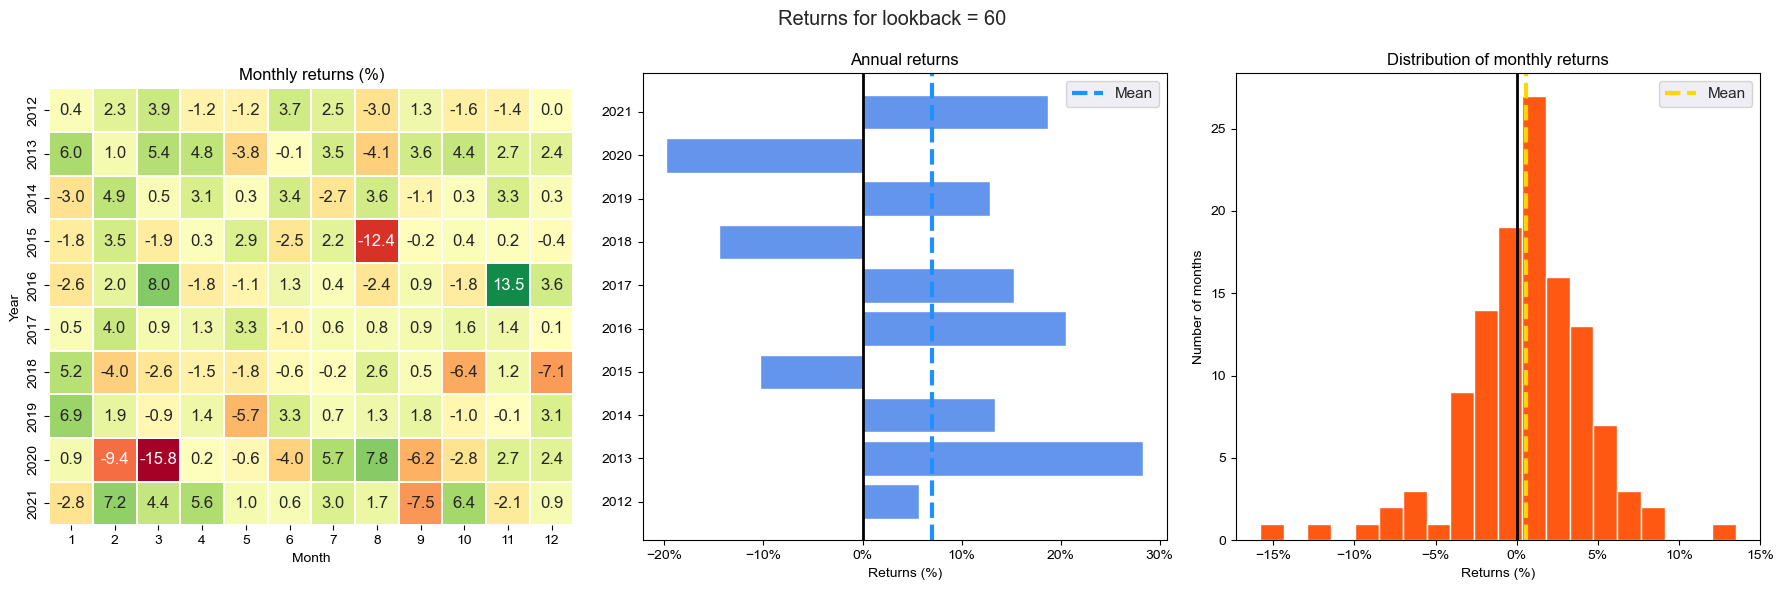

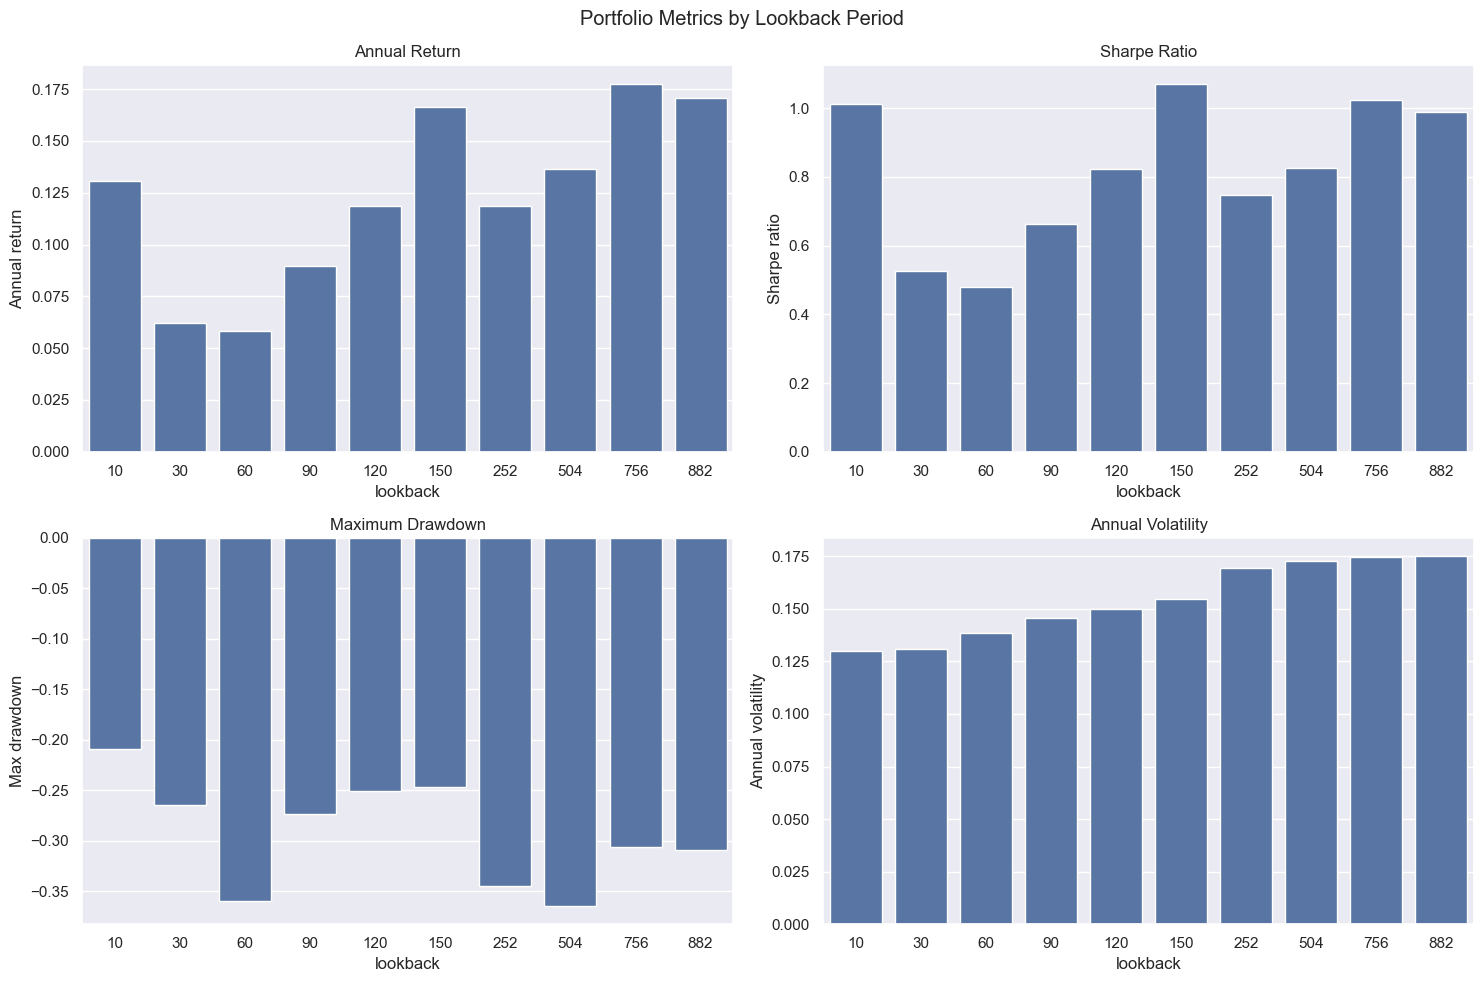


Detailed Metrics by Lookback Period:


lookback,10,30,60,90,120,150,252,504,756,882
Annual return,0.130727,0.061965,0.058310,0.089755,0.118614,0.166243,0.118407,0.136305,0.177595,0.170605
Cumulative returns,2.408159,0.822142,0.760512,1.358019,2.060800,3.640493,2.055163,2.579708,4.111547,3.816650
Annual volatility,0.129912,0.130842,0.138581,0.145722,0.150078,0.154859,0.169223,0.172857,0.174788,0.174987
Sharpe ratio,1.011018,0.525230,0.478801,0.662988,0.822094,1.070763,0.746749,0.826114,1.023351,0.988344
Calmar ratio,0.626028,0.234309,0.162316,0.328635,0.472815,0.674134,0.343456,0.374217,0.580584,0.552545
Stability,0.885025,0.884297,0.878286,0.872812,0.869506,0.865906,0.855269,0.852619,0.851218,0.851073
Max drawdown,-0.208820,-0.264457,-0.359236,-0.273114,-0.250867,-0.246602,-0.344752,-0.364241,-0.305891,-0.308762
Omega ratio,1.208735,1.100199,1.092727,1.133710,1.167020,1.226485,1.159109,1.178053,1.224495,1.216162
Sortino ratio,1.268641,0.641439,0.556166,0.795281,1.030295,1.349732,0.846042,0.982708,1.223065,1.179073
Skew,-0.349535,-0.737892,-1.221519,-0.326739,0.032278,0.146777,-1.024398,-0.311106,-0.490979,-0.491622


In [120]:
# Plot key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Portfolio Metrics by Lookback Period")

# Annual Return
sns.barplot(data=metrics_df, x="lookback", y="Annual return", ax=axes[0, 0])
axes[0, 0].set_title("Annual Return")

# Sharpe Ratio
sns.barplot(data=metrics_df, x="lookback", y="Sharpe ratio", ax=axes[0, 1])
axes[0, 1].set_title("Sharpe Ratio")

# Max Drawdown
sns.barplot(data=metrics_df, x="lookback", y="Max drawdown", ax=axes[1, 0])
axes[1, 0].set_title("Maximum Drawdown")

# Volatility
sns.barplot(data=metrics_df, x="lookback", y="Annual volatility", ax=axes[1, 1])
axes[1, 1].set_title("Annual Volatility")

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Metrics by Lookback Period:")
df = metrics_df.set_index("lookback")
df.T